This code models the jet-ISM interaction site near Cyg X-1, combines it with the measurements made of the site in radio wavelengths and establishes estimates of the age of the jet and the energy trasnported by the jet powering the interaction site. This requires the following steps:
1) User defined inputs that define various observed parameters pertaining to the bow shock.
2) Estimating the electron density of the shocked gas using both the L and S-band bow shock surface brightness (assuming a temperature range). Additionally, we use H-alpha surface brightness too.
3) Use the derived temperature and electron density ranges to estimate the velocity of the bow shock. 
4) Use the velocity and the characteristic length of the jet to find the age of the jets.
5) The age of the jet is then used to estimate the average energy transport rate.

In [49]:
import astropy
from astropy import units as u
from astropy.units import cds
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import matplotlib.gridspec as gridspec
from matplotlib import rc
from matplotlib import colors
import numpy as np
import numpy.ma as ma
import math
from scipy import interpolate
from scipy import optimize
from scipy.integrate import quad
from scipy.stats import rv_histogram

from scipy.stats import gaussian_kde,rv_continuous
from scipy.interpolate import interp1d

import scipy.special
import seaborn as sns
import pandas as pd

import joblib
from joblib import Parallel, delayed
import multiprocessing

import os


# Package versions:
print('Running on:')
print('Python version 3.6')
print(f'\tAstropy\t\t{astropy.__version__}')
print(f'\tMatplotlib\t{plt.matplotlib.__version__}')
print(f'\tNumpy\t\t{np.__version__}')
print(f'\tScipy\t\t{scipy.__version__}')
print(f'\tSeaborn\t\t{sns.__version__}')
print(f'\tPandas\t\t{pd.__version__}')
print(f'\tJoblib\t\t{joblib.__version__}')


Running on:
Python version 3.6
	Astropy		4.0.2
	Matplotlib	3.3.4
	Numpy		1.19.5
	Scipy		1.5.3
	Seaborn		0.11.2
	Pandas		1.1.5
	Joblib		0.13.2


In [50]:
# Set default figure size for all plots
plt.rcParams['figure.figsize'] = [12, 8]  # Width, Height in inches

#python3.6
rc('text', usetex=True)
font = {'family' : 'serif','size'   : 18}
rc('font', **font)

In [51]:
#New measured quantities in this work in L-band
F_total_L = 0.04693 #Integrated Bow shock flux in Jy
#F_total_L = 1.5e-4 #Integrated Bow shock flux in Jy if the bowshock was not deteted (sigma level)
F_L = 110e-6        #Mean Bow shock flux density in Jy/beam 
F_err_L = 1.5e-4    #rms around bowshock region
DRmin_L = 1.45      #Ring thickness, arcmin 
DRmin_err_L = 0.17
theam_L = 7.3       #Bubble diameter in arcmin (noted between the inner edges of the lobe)
disamin_L = 10.8    #angular seperation between Cyg X-1 and the leading edge of the bowshock in arcmin
disamin_err_L = 0.2 #beam size is taken as the error
proj_shock_L = 97771.6 #projected area of the bowshock in arcsec2 (used ds9 for this)

#New measured quantities in this work in S-band
F_total_S = 0.05927 #Integrated Bow shock flux in Jy
F_S = 38e-6         #Mean Bow shock flux density in Jy/beam 
F_err_S = 4.8e-5    #rms from bowshock region
DRmin_S = 1.39      #Ring thickness, arcmin 
DRmin_err_S = 0.18
theam_S = 7         #Lobe diameter in arcmin (noted between the inner edges of the lobe)
disamin_S = 10.5    #angular seperation between Cyg X-1 and the leading edge of the bowshock in arcmin
disamin_err_S = 0.12 #beam size is taken as the error
proj_shock_S = 95688.6 #projected area of the bowshock in arcsec2 (used ds9 for this)

#Source specific parameters obtained from Miller-Jones et al. 2021 
d = 2.2            #distance to Cyg X-1 in kpc
d_err = 0.18       #error in distance measured 
incl = 27.51       #inclination angle
incl_err = 0.18    #error inclination angle, Miller-Jones et al. 2021
o_a = 30           #opening angle
o_a_err = 0        #opening angle error

In [52]:
#Constants
n_iter = 5000
n_cores = 16         # Number of parallel threads
pc = 3.086E+18       # 1 pc, cm 
mh = 1.6735575E-24   # Hydrogen mass, g 
me = 9.1093837E-28   # Electron mass, g 
eV = 1.602176634E-12 # ElectronVolt, erg
Jy = 1.0E-23         # 1 Jansky (erg/s/cm2/Hz), cgs
kb = 1.380649E-16;   # K boltzman, cgs
h =  6.6261E-27;     # Plank constant, cgs 
c = 3.0e10           # Speed of light, cgs 
Na = 6.022E+23       # Avogadro's number
Z=1                  # Hydrogen atomic number
e = 4.8e-10          #electric charge cm3/2 g1/2 s-1
x=1                  #ionisation fraction
C_radio = 6.8*1e-38
Gammac = 5/3                            # Adiabatic index of the material in the cavity, -- ASSUMED 
Gammax = 5/3                            # Adiabatic index of the material in the external medium, -- ASSUMED 
Gammaj = 5/3                            # Adiabatic index of the material in the jet, -- ASSUMED 
beta = 0                                # density profile index (beta = 0 for a uniform density medium), -- ASSUMED 

# Observation-specific quantities L-band
nu_L = 1.2839E+9;         # Observing frequency (L-band, MeerKAT, slightly lower than for Cyg X-1, Westerbork)
bmaj_L = 14.26            # Beam major axis, arcsec
bmin_L = 14.26            # Beam minor axis, arcsec

# Observation-specific quantities S-band
nu_S = 2.624E+9;         # Observing frequency (L-band, MeerKAT, slightly lower than for Cyg X-1, Westerbork)
bmaj_S = 7.009            # Beam major axis, arcsec
bmin_S = 7.009            # Beam minor axis, arcsec

## Conversion of the newly measured source specific quantities L-band

In [53]:
#various aspects of the ring thickness
DR_L = DRmin_L*60            #Ring thickness, arcsec
DRpc_L = d*1e3*4.8*1e-6*DR_L #Ring thickness in pc (have to convert d to pc from kpc too)
DRcm_L = DRpc_L*pc           #Ring thickness in cm 

DR_err_L = DRmin_err_L*60
DRpc_err_L = d*1e3*4.8*1e-6*DR_err_L #Ring thickness in pc (have to convert d to pc from kpc too)
DRcm_err_L = DRpc_err_L*pc           #Ring thickness in cm 

#various aspects of the area of of the bowshock
proj_shock_pc_L = proj_shock_L*(d*1e3*4.8*1e-6)**2 #convert area from arcsec to pc
proj_volume_pc_L = DRpc_L*proj_shock_pc_L          #convert the pc area to pc volume
proj_vol_cm_L = proj_volume_pc_L*((pc)**3)         #convert the pc volume to cm3 volume

#Various aspects of the lobe diameter
lobesize_as_L = theam_L*60                     #lobe diameter in arcseconds
lobesizepc_L = lobesize_as_L*d*1e3*4.8*1e-6    #lobe diameter in pc
lobesizecm_L = lobesizepc_L*pc                 #lobe diameter in cm

#Various aspects of the angular seperation between the target and the leading edge of the bowshock
disasec_L = disamin_L*60                          #lobe target seperation in arcsec (projected)
dispc_L = disasec_L*d*1e3*4.8*1e-6                #lobe target separation in pc (projected)
discmP_L = dispc_L*pc                             #lobe target sepeartion in cm (projected)
discm_deP_L = discmP_L/math.sin(incl*math.pi/180) #lobe target de-projected seperation to account for the inclination angle

#Printing the estimated values
print('Bow shock thickness in cm -','%.3e'%DRcm_L)
print('Diameter of the bowshock in cm -', '%.3e'%lobesizecm_L)
print('Seperation between Cyg X-1 and the bowshock in cm (de-projected) -', '%.3e'%discm_deP_L) #Lj
print('Bow shock thickness in pc -','%.3f'%DRpc_L)
print('Diameter of the bowshock in pc -', '%.3f'%lobesizepc_L)
print('Seperation between Cyg X-1 and the bowshock in pc (projected) -', '%.3f'%dispc_L) #Lj
print('Bow shock Volume in pc3 -','%.3e'%proj_volume_pc_L)
print('Bow shock Area in pc2 -','%.3e'%proj_shock_pc_L)

Bow shock thickness in cm - 2.835e+18
Diameter of the bowshock in cm - 1.427e+19
Seperation between Cyg X-1 and the bowshock in cm (de-projected) - 4.572e+19
Bow shock thickness in pc - 0.919
Diameter of the bowshock in pc - 4.625
Seperation between Cyg X-1 and the bowshock in pc (projected) - 6.843
Bow shock Volume in pc3 - 1.002e+01
Bow shock Area in pc2 - 1.090e+01


## Conversion of the newly measured source specific quantities S-band

In [54]:
DR_S = DRmin_S*60            #Ring thickness, arcsec
DRpc_S = d*1e3*4.8*1e-6*DR_S #Ring thickness in pc (have to convert d to pc from kpc too)
DRcm_S = DRpc_S*pc           #Ring thickness in cm 

DR_err_S = DRmin_err_S*60
DRpc_err_S = d*1e3*4.8*1e-6*DR_err_S #Ring thickness in pc (have to convert d to pc from kpc too)
DRcm_err_S = DRpc_err_S*pc           #Ring thickness in cm 

#various aspects of the area of of the bowshock
proj_shock_pc_S = proj_shock_S*(d*1e3*4.8*1e-6)**2 #convert area from arcsec to pc
proj_volume_pc_S = DRpc_S*proj_shock_pc_S          #convert the pc area to pc volume
proj_vol_cm_S = proj_volume_pc_S*((pc)**3)         #convert the pc volume to cm3 volume

#Various aspects of the lobe diameter
lobesize_as_S = theam_S*60                     #lobe diameter in arcseconds
lobesizepc_S = lobesize_as_S*d*1e3*4.8*1e-6    #lobe diameter in pc
lobesizecm_S = lobesizepc_S*pc                 #lobe diameter in cm

#Various aspects of the angular seperation between the target and the leading edge of the bowshock
disasec_S = disamin_S*60                          #lobe target seperation in arcsec (projected)
dispc_S = disasec_S*d*1e3*4.8*1e-6                #lobe target separation in pc (projected)
discmP_S = dispc_S*pc                             #lobe target sepeartion in cm (projected)
discm_deP_S = discmP_S/math.sin(incl*math.pi/180) #lobe target de-projected seperation to account for the inclination angle

#Printing the estimated values
print('Bow shock thickness in cm -','%.3e'%DRcm_S)
print('Diameter of the bowshock in cm -', '%.3e'%lobesizecm_S)
print('Seperation between Cyg X-1 and the bowshock in cm (de-projected) -', '%.3e'%discm_deP_S) #Lj
print('Bow shock thickness in pc -','%.3f'%DRpc_S)
print('Diameter of the bowshock in pc -', '%.3f'%lobesizepc_S)
print('Seperation between Cyg X-1 and the bowshock in pc (projected) -', '%.3f'%dispc_S) #Lj
print('Bow shock Volume in pc3 -','%.3e'%proj_volume_pc_S)
print('Bow shock Area in pc2 -','%.3e'%proj_shock_pc_S)

Bow shock thickness in cm - 2.718e+18
Diameter of the bowshock in cm - 1.369e+19
Seperation between Cyg X-1 and the bowshock in cm (de-projected) - 4.445e+19
Bow shock thickness in pc - 0.881
Diameter of the bowshock in pc - 4.435
Seperation between Cyg X-1 and the bowshock in pc (projected) - 6.653
Bow shock Volume in pc3 - 9.398e+00
Bow shock Area in pc2 - 1.067e+01


### Finding the electron density and temperature

The monochromatic emissivity $\epsilon_\nu$ of ionised hydrogen due to thermal bremsstrahlung is given by (Longair 1994). 

 $$\epsilon_\nu = \frac{L_\nu}{V} = 6.8\times 10^{-38} g(\nu, T) \frac{n_e^2}{\sqrt{T}} \exp{(\frac{h\nu}{k_b T})} ~~ erg~s^{-1}~cm^{-3}~Hz^{-1}$$

where $V$ is the volume of the emitting region. The area of the bow shock region in determined in arcsec^2 and multiplied by the thickness of the ring to estimate V. Assumption: The bow shock structure is as deep as it is wide. 

$$
L_\nu = F_\nu \times 4\pi \times d^2
$$
, which is the monochromatic luminosity. In the case of MeerKAT, we use monochromatic flux density ($F_\nu$) to present the flux density of a flat spectrum source at the central frequency of the observing band. Another thing to note is that this is the integrated flux of the bowshock, as we are using the total volume of the emitting region to find the emissivity.

From the Bremsstrahlung emissivity we can derive the electron density, and from there the total number of particles based on the expected ionisation fraction $x \sim 1$ of a hydrogen gas emitting at a minimum temperature of T $\sim 10{^4}$ K. At these temperatures almost all hydrogen will be ionised, so the ionisation fraction is 1.

$$n_e = \sqrt\frac{\epsilon_\nu}{g(\nu, T) \sqrt{T} C_{radio}}$$

where,

$$ 
C_{radio} = 6.8\times 10^{-38} erg~s^{-1}~cm^{-3}~Hz^{-1} 
$$,

$$
g(\nu, T) \approx \frac{\sqrt{3}}{2 \pi}\left[\ln \left(\frac{128 \epsilon_0^2 k^3 T^3}{m_e e^4 \nu^2 Z^2}\right)-\gamma^2\right]
$$

### To calculate the electron density using MC

In [55]:
def gaunt(nu, T, z):
    # The Gaunt factor  
    F1 = 128.*(1**2)*(kb**3)*(T**3)
    F2 = me * (e**4)*(nu**2)*(z**2)
    G = (3**0.5 / (2.*np.pi)) * (np.log(F1/F2) - 0.5772156649**2)
    return G

In [56]:
class custom_dist_analytical(rv_continuous):
    def _pdf(self, xx):
        return testf(xx)

np.random.seed(124)

In [57]:
def ne(d,F,DR,T_axis,nu,Z,proj_shock):
    L14 = F*Jy*4*math.pi*(d*1e3*pc)**2 # Monochormatic ring luminosity in erg/sec/Hz
    Vol = (DR*proj_shock*(d*1e3*4.8*1e-6*pc)**3)
    kappa_nu = L14 / Vol
    ne_squared = kappa_nu/(C_radio*(T_axis**-0.5) * gaunt(nu, T_axis, Z))
    n_e = (ne_squared**0.5)           # units: cm^-3
    return n_e


In [58]:
# Creating distributions for source parameters that remain unchanged for both frequencies parameters:
dist = np.random.normal(d,d_err, n_iter)
T_axis_log = np.logspace(np.log10(10**4), np.log10(3*(10**6)), num=n_iter, base=10, endpoint=True) #using upper limit derived from X-ray non-detection

In [59]:
#Creating distributions for source parameters that change for each frequency
Flux_L = np.random.normal(F_total_L,F_err_L,n_iter)
Ring_thic_L = np.random.normal(DR_L,DR_err_L,n_iter) #ring thickness in arcsec
Flux_S = np.random.normal(F_total_S,F_err_S,n_iter)
Ring_thic_S = np.random.normal(DR_S,DR_err_S,n_iter) #ring thickness in arcsec

In [60]:
elec_density_L = Parallel(n_jobs=n_cores,verbose=5)(delayed(ne)(dist[i],Flux_L[i],Ring_thic_L[i],T_axis_log[i],nu_L,Z,proj_shock_L) for i in range(n_iter))
elec_density_S = Parallel(n_jobs=n_cores,verbose=5)(delayed(ne)(dist[i],Flux_S[i],Ring_thic_S[i],T_axis_log[i],nu_S,Z,proj_shock_S) for i in range(n_iter))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.4s finished


23.670004981957383 15.831041516334846 35.59340518219809


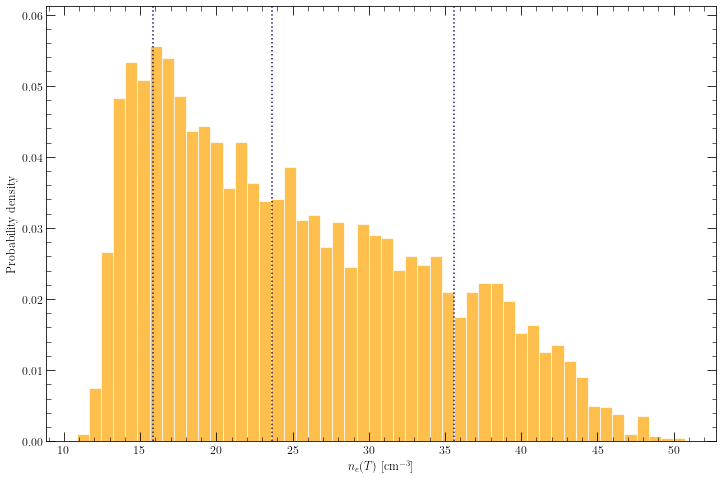

In [61]:
#Plotting histogram of electron density using L-band observations
median_L = np.nanpercentile(elec_density_L,50)
low_lim_L = np.nanpercentile(elec_density_L,16)
high_lim_L = np.nanpercentile(elec_density_L,84)
print(median_L,low_lim_L,high_lim_L)
histplot = plt.hist(elec_density_L,bins=50,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim_L,high_lim_L],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median_L,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel(r'$n_e(T)$ [cm$^{-3}$]', fontsize=12)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
plt.show()

27.961366190880163 18.724041132293276 42.13326324437815


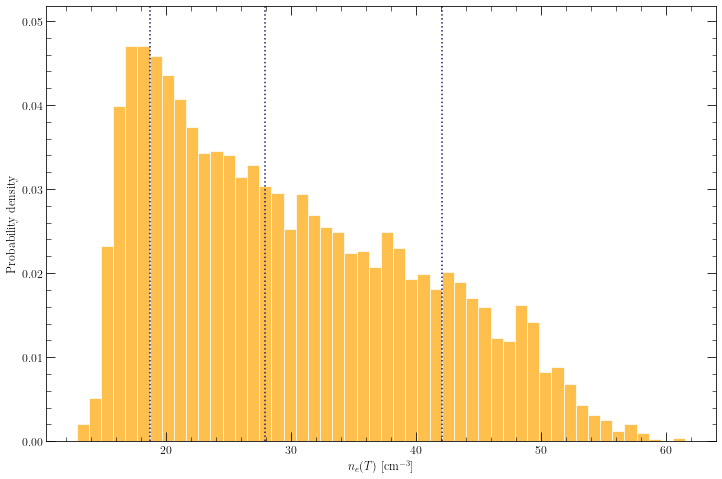

In [62]:
#Plotting histogram of electron density using S-band observations

median_S = np.nanpercentile(elec_density_S,50)
low_lim_S = np.nanpercentile(elec_density_S,16)
high_lim_S = np.nanpercentile(elec_density_S,84)
print(median_S,low_lim_S,high_lim_S)
histplot = plt.hist(elec_density_S,bins=50,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim_S,high_lim_S],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median_S,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel(r'$n_e(T)$ [cm$^{-3}$]', fontsize=12)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
plt.show()

## Calculating electron density with H alpha observations

We can find a similar relation by considering the H $\alpha$ surface brightness. For this, we can use the equation in Gvaramadze et al. (2018):

$$j_{\rm H\alpha} = 2.85\times10^{-33}\text{erg s}^{-1}\text{ cm}^{-3}\text{ arcsec}^{-2} \left( \frac{T}{\text{K}} \right)^{-0.9}\left(\frac{n_e}{\text{cm}^{-3}}\right)^2$$

The temperature and $n_e$ depend on position, but in our analysis, we have assumed they are uniform with depth. So then, we find that the surface brightness is given by:

$$S_{\rm H\alpha} = \int j_{\rm H\alpha}(x) dx = j_{\rm H\alpha} \Delta$$

Thus:

$$n_e(T) = \sqrt{S_{\rm H\alpha}\frac{(T/\text{K})^{0.9}}{C_{\rm H\alpha}\Delta}} \text{ cm}^{-3}$$ 

where $C_{\rm H\alpha} = 2.85\times10^{-33}\text{erg s}^{-1}\text{ cm}^{-3}\text{ arcsec}^{-2}$ and $\Delta$ is the width of the bowshock in cm.
The temperature range used is defined by the range of temperatures where the above equation is valid.



In [63]:
Sh = 1.3e-16 * u.erg * ((u.second)**-1)*((u.cm)**-2)*((u.arcsecond)**-2) #obtained from Sell et al. 2015 has the units ergs s-1 cm-2 arcsec-2
Sh_err = 1.3e-17                                                         #assuming a 10% error margin on Sh
Ch = 2.85e-33* u.erg * ((u.second)**-1)*((u.cm)**-3)*((u.arcsecond)**-2) #Units of erg s-1 cm-3 arcsec-2
Halpha_thic_min = 6*u.arcsecond                                          #min thickness from Russell 2007
Halpha_thic_max = 40*u.arcsecond                                         #max thickness from Russell 2007

D = 2.2e3 *u.parsec
Halpha_thic_min_arcsec = Halpha_thic_min.to(u.arcsec)
arcsec_to_size = (1 * u.arcsec).to(u.radian).value * D                   #the conversion between arcsecond to size at the distance of Cyg X-1
Halpha_thic_min_parsec = (Halpha_thic_min.value*arcsec_to_size)
Halpha_thic_min_cm = Halpha_thic_min_parsec.to(u.cm)

Halpha_thic_max_arcsec = Halpha_thic_max.to(u.arcsec)
Halpha_thic_max_parsec = (Halpha_thic_max.value*arcsec_to_size)
Halpha_thic_max_cm = Halpha_thic_max_parsec.to(u.cm)

Ring_thic_tab2 = 1.6e18*u.cm                                            #russell 2007 average thickness in Table 2 to be used for calculations here
Ring_thic_tab2_err = 1.6e17*u.cm                                        #assuming 10% error

def ha_ne(S,T,Ring):
    Ha_ne = ((S*(T**0.9))/(Ch.value*Ring))**0.5
    return(Ha_ne)

def T_alpha(ne_alpha, S, Ring):
    temp_range_alpha = ((((ne_alpha)**2)*(Ch.value*Ring))/S)**0.9
    return(temp_range_alpha)


In [64]:
# Create distributions to use as input for H_alpha temperature determination
# Source parameters, :
Halpha_Flux = np.random.normal(Sh.value,Sh_err,n_iter)
Ring_thic_cm = np.random.normal(Ring_thic_tab2.value,Ring_thic_tab2_err.value,n_iter)
T_axis_alpha_log = np.logspace(np.log10(5000), np.log10(20000), num=n_iter, base=10, endpoint=True)

In [65]:
#range of ne densities based on the considered temperature range
elec_density_Ha = Parallel(n_jobs=n_cores,verbose=5)(delayed(ha_ne)(Halpha_Flux[i],T_axis_alpha_log[i],Ring_thic_cm[i]) for i in range(n_iter))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.7s finished


10.656942915964173 8.591896739807469 13.204183231132662


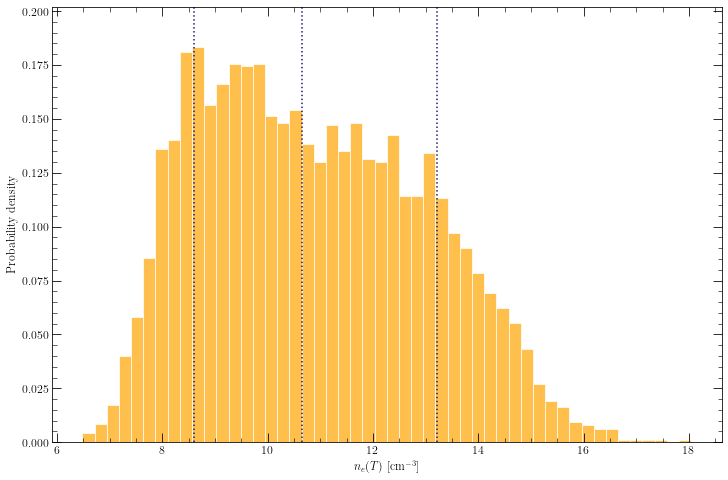

In [66]:
#Plotting histogram of electron density using Halpha observations
median = np.nanpercentile(elec_density_Ha,50)
low_lim = np.nanpercentile(elec_density_Ha,16)
high_lim = np.nanpercentile(elec_density_Ha,84)
print(median,low_lim,high_lim)
histplot = plt.hist(elec_density_Ha,bins=50,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel(r'$n_e(T)$ [cm$^{-3}$]', fontsize=12)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
plt.show()

## Shock velocity measurement:

Velocity of the bow shock can be estimated by the velocity of the leading end of the shock, which is dictated by the velocity of the end of the shocking jet.

$$ \dot{L} = \sqrt{\frac{16 k_b}{3 m_p}T}$$

where $m_p$ is the mass of the proton. 
For a strong shock in a mono-atomic gas, the expansion velocity is set by the temperature of the shocked gas. If the shock is radiative the initial post-shock temperature can be higher than that of the thermalized, bremsstrahlung-emitting gas. A stringent constraint comes from X-ray observations and the upper limit to the gas temperature was set at T ~ 10 $^6$ K in G05. 

In [67]:
T_axis_log = np.logspace(np.log10(10**4), np.log10(3*(10**6)), num=n_iter, base=10, endpoint=True) #using upper limit derived from X-ray non-detection
v_range = ( (16*T_axis_log*kb)/(3*mh) )**(1/2)/1e5
v_range_cm = ( (16*T_axis_log*kb)/(3*mh) )**(1/2)

Velocity range 20.975903969816827 363.3133141040846


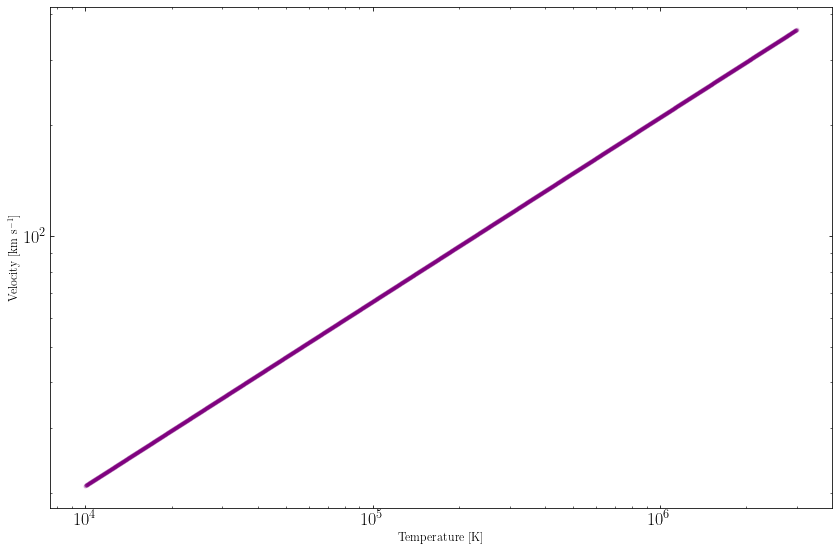

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Temperature [K]', fontsize=12)
ax.set_ylabel(r'Velocity [km s$^{-1}$]', fontsize=12)
plt.tight_layout()
plt.scatter(T_axis_log,v_range,s=10,color='purple',alpha=0.1)
print('Velocity range',v_range[0],v_range[n_iter-1])

## Jet age measurement:

$$ t = \frac{3 L_j}{5 \dot{L_j}} $$

where $L_j$ is the seperation between the leading edge of the bowshock and the target and $\dot{L_j}$ is the velocity of the bow shock estimated from the temperature of the ISM. Since the angular seperation between the leading edge of the bow shock and Cyg X-1 is the same in both the L and S-band, we use only one velocity estimate to derive the jet age, and more appropriately S-band due to the higher resolution measurement. 

In [69]:
def age(disamin,d,incl,v):
    disasec = disamin*60                      #lobe target seperation in arcsec (projected)
    dispc = disasec*d*1e3*4.8*1e-6            #lobe target separation in pc (projected)
    discmP = dispc*pc                         #lobe target sepeartion in cm (projected)
    discm = discmP/math.sin(incl*math.pi/180) #lobe target de-projected seperation to account for the inclination angle
    t = 3/5*(discm/v)                         #time in seconds
    t_age_Myr = t/(365.*24.*60*60)/1.0E+6     #age of shock in Myr
    return t_age_Myr
    

In [70]:
# Generating distribution arrays for measurements
len_min = np.random.normal(disamin_S,disamin_err_S, n_iter) #distance between bowshock and target in arcmin
i_angle = np.random.normal(incl,incl_err,n_iter)            #inclination angle
#Obtaining distribution of age for different input parameters
t_age = Parallel(n_jobs=n_cores,verbose=5)(delayed(age)(len_min[i],dist[i],i_angle[i],v_range_cm[i]) for i in range(n_iter))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 304 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.3s finished


0.09705886332386533 0.03673806099212476 0.25510151355288957


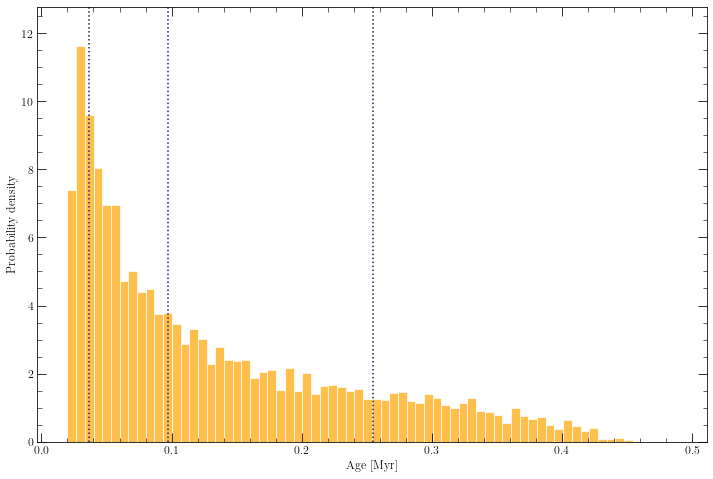

In [71]:
median = np.percentile(t_age,50)
low_lim = np.percentile(t_age,16)
high_lim = np.percentile(t_age,84)
print(median,low_lim,high_lim)
histplot = plt.hist(t_age,bins=70,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Age [Myr]', fontsize=12)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
plt.show()

The evolution of the large-scale structure created by the jet (lobe and bow shock), is self-similar once the jet extends beyond its characteristic length scale, given by (Kaiser et al. 1997):
$$ L_0 = (\frac{\rho_0^2 Q_0}{\dot{M}_0^3})^{-1/4} = [\frac{Q_0^2}{\rho_0^2 c^6(\gamma_j -1)}]^{1/4}$$

where $\dot{M_0}$ is the mass transport rate of the jet, and $\gamma_j$ is the Lorentz factor of the jet material.


gamma is assumed as 1.1, which maximizes $L_{0}$

It is clear that the modelling can be applied, given the characteristic length is smaller than the scale of the jet length.


In [72]:
# Calculation of L0
rho0 = 2.0e-23 #density in g/cm3
gammaj = 1.1
Q0 = 1.0E+37
L0 = ( (Q0**2) / (rho0**2*c**6*(gammaj-1)) )**(1/4)
print('Characteristic jet length scale [pc] (L0) = ', '{:.3e}'.format(L0/pc))
print('Jet length [pc] (Lj) = ', '{:.3e}'.format(discmP_L/pc))


Characteristic jet length scale [pc] (L0) =  7.842e-05
Jet length [pc] (Lj) =  6.843e+00


Assuming that the jet direction remains constant over time,  and that the jet is colliding with a medium of density $\rho_0$, the power $Q_{jet}$ being transported by the jets averaged over its lifetime is solely dependent on the properties of the ISM at the interaction site. Combining the equations for $L_j$ and $\dot{L_j}$ we obtain: 


$$ Q_{jet} = (\frac{5}{3})^3~\frac{\rho_0}{C1^5}L_j^2 ~\dot{L_j}^3$$

Things to note here are the differences with the literature. For eg. the C1 constant here has been used as an assumed value of 1 in Gallo et al. 2005 and as 1.5 in Kaiser et al. 2004. The constant C1 depends on the jet opening angle, and a value of 1 implies a jet opening angle of 90deg (unrealistic). The better option is to use measured values of the opening angle. So, we will instead calculate C1 for a range of the measured opening angle of Cyg X-1 and also for a more conservative range of 0-30 deg.

The pressure inside the lobe is given by: 

$$ p = 0.0675 \frac{C_1^{10/3}}{R^2}(\frac{\rho_0 Q_0^2}{L_j^4})^{1/3}$$


In [73]:
def power(theta,nee,disamin,vcm):
    theta_rad = theta*math.pi/180            #Jet opening angle, in radians
    C2 = (((Gammac-1)*(Gammaj-1))/(4*Gammac) + 1 )**(Gammac/(Gammac-1)) * ((Gammaj+1)/(Gammaj-1))
    Rax = math.sqrt((1/4*(C2/theta_rad**2))) #axial ratio of the jet-blown cavity                         
    C3 = math.pi/(4*Rax**2)
    C1 = ((C2)/(C3*theta_rad**2)*((Gammax+1)*(Gammac-1)*(5-beta)**3)/(18*(9*(Gammac + (Gammac -1)*(C2/(4*theta_rad**2))) - 4 - beta)) )**(1/(5-beta))
    rho = nee*1.370*mh;                      #Density of the gas down-stream of the shock, in cm-3 
    rho0 = rho/4;                            #Density of the gas, up-stream of the shock, in cm-3
    disasec = disamin*60                     #lobe target seperation in arcsec (projected)
    dispc = disasec*d*1e3*4.8*1e-6           #lobe target separation in pc (projected)
    discmP = dispc*pc                        #lobe target sepeartion in cm (projected)
    discm = discmP/math.sin(incl*math.pi/180) #lobe target de-projected seperation to account for the inclination angle
    Pjet = (5/3)**3 * rho0/(C1**5)*discm**2*vcm**3   
    return Pjet

In [74]:
def press(theta,d,nee,disamin,vcm):
    beta = 0
    theta_rad = theta*np.pi/180            # Jet opening angle, in radiants
    Con2 = (((Gammac-1)*(Gammaj-1))/(4*Gammac) + 1 )**(Gammac/(Gammac-1)) * ((Gammaj+1)/(Gammaj-1))
    Rax = np.sqrt((1/4*(Con2/theta_rad**2))) # axial ratio of the jet-blown cavity                         
    Con3 = np.pi/(4*Rax**2)
    Con1 = ((Con2)/(Con3*theta_rad**2)*((Gammax+1)*(Gammac-1)*(5-beta)**3)/(18*(9*(Gammac + (Gammac -1)*(Con2/(4*theta_rad**2))) - 4 - beta)) )**(1/(5-beta))  
    rho = nee*1.370*mh;                    # Density of the gas down-stream of the shock, in cm-3 (calculated above with the calorimetry method above)
    rho0 = rho/4;                          # Density of the gas, up-stream of the shock, in cm-3
    disasec = disamin*60                   # lobe target seperation in arcsec (projected)
    dispc = disasec*d*1e3*4.8*1e-6         # lobe target separation in pc (projected)
    discmP = dispc*pc                      # lobe target sepeartion in cm (projected)
    discm = discmP/np.sin(incl*np.pi/180)  # lobe target de-projected seperation to account for the inclination angle
    Pjet = (5/3)**3 * rho0/(Con1**5)*(discm**2)*vcm**3   # Upper limit to time averaged jet power 
    pminjet = 0.0675*(Con1**(10/3)/Rax**2)*(rho0*Pjet**2/(discm**4))**(1/3)
    return pminjet


In [87]:
# Generating distribution arrays for measurements
#open_angle = np.random.uniform(0,30, n_iter) #using more conservative opening angle
open_angle = np.logspace(np.log10(0.3),np.log10(2),num=n_iter,base=10,endpoint=True)
ne_constrained = np.random.uniform(19,42,n_iter) #from the constraints using S-band radio fluxes
#Obtaining distribution of power for different input parameters
power_j = Parallel(n_jobs=n_cores,verbose=5)(delayed(power)(open_angle[i],ne_constrained[i],len_min[i],v_range_cm[i]) for i in range(n_iter))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 473 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    1.7s finished


1.5542849002094103e+33 2.344998929790839e+31 1.0522559944140773e+35


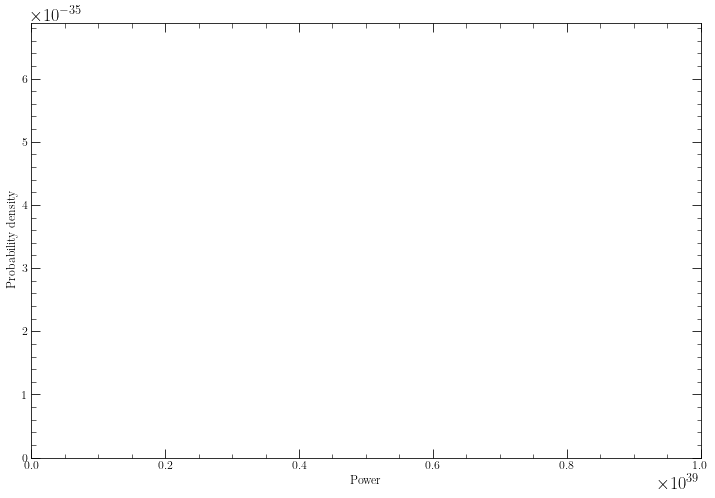

In [88]:
median = np.percentile(power_j,50)
low_lim = np.percentile(power_j,16)
high_lim = np.percentile(power_j,84)
print(median,low_lim,high_lim)
histplot = plt.hist(power_j,color='orange',bins=100,edgecolor='w',density=True,alpha=0.7)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Power', fontsize=12)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
plt.show()

In [77]:
#calculating pressure inside bowshock
pressure_j = Parallel(n_jobs=n_cores,verbose=5)(delayed(press)(open_angle[i],dist[i],ne_constrained[i],len_min[i],v_range_cm[i]) for i in range(n_iter))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 528 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.4s finished


3.9485140568929913e-14 1.5274121583763713e-15 9.471587886519662e-13


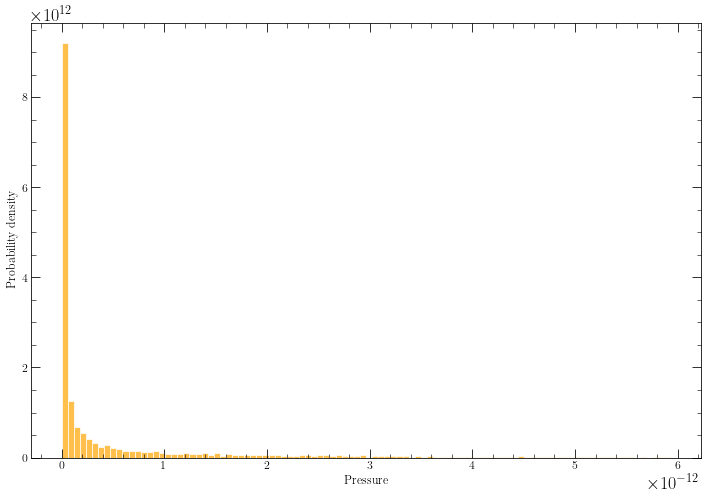

In [78]:
median = np.percentile(pressure_j, 50)
low_lim = np.percentile(pressure_j, 16)
high_lim = np.percentile(pressure_j, 84)
print(median, low_lim, high_lim)
histplot = plt.hist(pressure_j, color='orange', bins=100, edgecolor='w', density=True, alpha=0.7)
#plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
#plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
#plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Pressure', fontsize=12)
#plt.xlim(0,1e39)
#plt.title(str(name))
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both', direction='in', right=True, top=True)
plt.show()